In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from modopt.opt.proximity import SparseThreshold
from modopt.opt.linear import Identity
from mri.operators import FFT, WaveletN
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
import numpy as np
from tqdm.notebook import tqdm

from fastmri_recon.data.fastmri_sequences import Masked2DSequence
from fastmri_recon.helpers.utils import crop_center
from fastmri_recon.helpers.evaluate import psnr, ssim
from fastmri_recon.helpers.evaluate import METRIC_FUNCS, Metrics

/volatile/home/Zaccharie/workspace/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/volatile/home/Zaccharie/workspace/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.3     installed
numpy          : >=1.16.4  - required | 1.17.4    installed
matplotlib     : >=3.0.0   - required | 3.1.2     installed
astropy        : >=3.0.0   - required | 4.0       installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.2     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# paths
train_path = '/media/Zaccharie/UHRes/singlecoil_train/singlecoil_train/'
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
test_path = '/media/Zaccharie/UHRes/singlecoil_test/'

n_volumes_train = 973
n_volumes_val = 199

In [4]:
# generators
# CORPDFS_FBK CORPD_FBK None
AF = 4
train_gen = Masked2DSequence(train_path, af=AF, inner_slices=1, contrast='CORPDFS_FBK')
val_gen = Masked2DSequence(val_path, af=AF, contrast='CORPDFS_FBK')

In [5]:
def reconstruct_image(kspace, mask, orig_image, max_iter=200, mu=0.1):
    def _psnr(x):
        x_fastmri = crop_center(np.abs(x), 320)
        return psnr(orig_image, x_fastmri)
    
    kspace_squeeze = np.squeeze(kspace)
    mask = np.squeeze(mask)
    k_shape = kspace_squeeze.shape
    kspace_loc = convert_mask_to_locations(mask)
    fourier_op = FFT(samples=kspace_loc, shape=k_shape)
    linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
    regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")
    reconstructor = SingleChannelReconstructor(
        fourier_op=fourier_op,
        linear_op=linear_op,
        regularizer_op=regularizer_op,
        gradient_formulation='synthesis',
        verbose=0,
    )
    x_final, costs, metrics = reconstructor.reconstruct(
        kspace_data=kspace_squeeze,
        optimization_alg='fista',
        num_iterations=max_iter,
        restart_strategy='greedy',
        xi_restart=0.96, 
        s_greedy=1.3,
#         metric_call_period=None,
        progress=False,
        cost_op_kwargs={'cost_interval': 5},
        metrics={
            "psnr": {"metric": _psnr, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
        },
        metric_call_period=5,
    )
    image_rec_fs = crop_center(np.abs(x_final), 320)
    return image_rec_fs, metrics, costs

def reconstruct_zero(kspace, mask):
    kspace_squeeze = np.squeeze(kspace)
    mask = np.squeeze(mask)
    k_shape = kspace_squeeze.shape
    kspace_loc = convert_mask_to_locations(mask)
    fourier_op = FFT(samples=kspace_loc, shape=k_shape)
    x = fourier_op.adj_op(kspace_squeeze)
    image_rec_fs = crop_center(np.abs(x), 320)
    return image_rec_fs

In [6]:
(kspace, mask), orig_image = train_gen[100]

In [7]:
x_final, metrics, costs = reconstruct_image(kspace, mask, np.squeeze(orig_image), mu=1e-7)
x_zero = reconstruct_zero(kspace, mask)

/volatile/home/Zaccharie/workspace/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/evaluate.py:24: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=gt.max() - gt.min())


In [8]:
base_psnr = psnr(np.squeeze(orig_image), x_zero)

In [9]:
m = metrics['psnr']

<IPython.core.display.Javascript object>


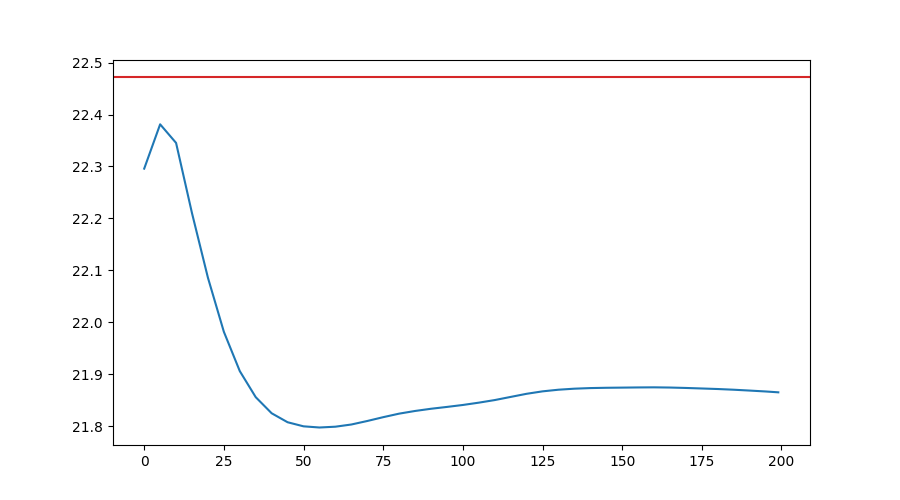

In [10]:
plt.figure()
plt.plot(m['index'], m['values'])
plt.axhline(base_psnr, color='C3')

<IPython.core.display.Javascript object>


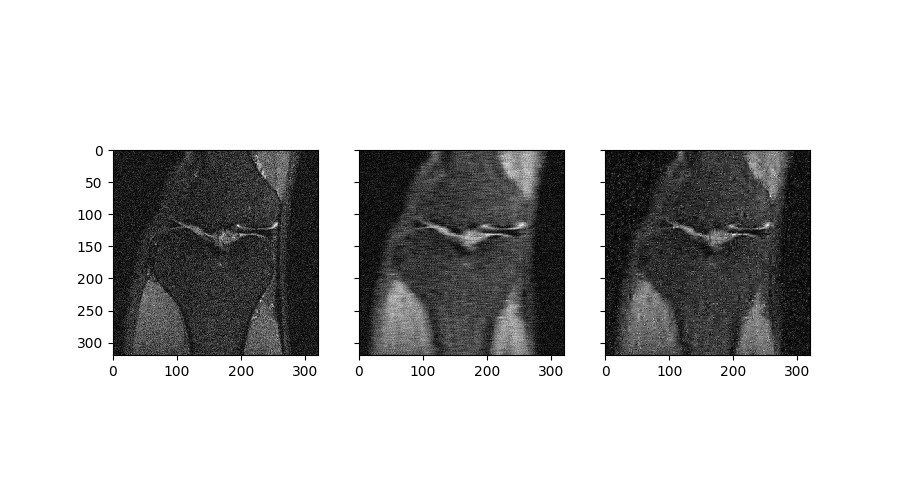

In [11]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].imshow(np.squeeze(orig_image))
axs[1].imshow(x_zero)
axs[2].imshow(x_final)